In [1]:
import os
from  PIL  import   Image,ImageFont,ImageDraw


In [2]:
max_photo = 5000

In [39]:
#删除数据集
for i in os.scandir(r"train_data"):
    if os.path.isfile(i.path):
        os.remove(i.path)
for i in os.scandir(r"test_data"):
    if os.path.isfile(i.path):
        os.remove(i.path)

In [4]:
with open ("text.txt","r",encoding="utf-8") as f:
    text = f.read()
    text_list = eval(text)

# text_list

In [5]:
#生成数据集
i = 0

for text in text_list:
    if i > max_photo:
        break
    if len(text) > 1:
        continue
    im = Image.new("RGB", (32, 32), (255, 255, 255))
    dr = ImageDraw.Draw(im)
    font = ImageFont.truetype(os.path.join( "FZZJ-JHTJW.TTF"), 32)
    dr.text((0, 0), text, font=font, fill="#000000")
    im.save("train_data/{}_{}.png".format(text,i))
    im.save("test_data/{}_{}.png".format(text,i))
    
    
    i+= 1

In [34]:
i = 0
text_json = {}
for text in text_list:
    if i > max_photo:
        break
    if len(text) > 1:
        continue
    text_json[i] = text 
    i+= 1

n_classfication = i

with open ("text_json.txt","w",encoding="utf-8") as f:
    f.write(str(text_json))

In [7]:
from torch.utils.data import Dataset
import os
import math
import torch
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import time
import numpy as np
import re
import random

In [8]:
os.environ["KMP_DUPLICATE_LIB_OK"]  =  "TRUE"
class ImgDataset(Dataset):
    def __init__(self,transform=None,train=True):
        

        
        self.transform = transform
        self.img_path  = []
        if train:

            self.img_path = self.get_img_path_list(True)
        else:
            self.img_path = self.get_img_path_list(False)


        self.img_len = len(self.img_path)

    def get_img_path_list(self,istrain):
        def train():
            draw_list = []
            
            for i in os.scandir(r"train_data"):
                if i.name == r".ipynb_checkpoints":
                    continue
                for j in range(10):
                    draw_list.append(i.path)
            return draw_list


        def test():
            draw_list = []
            
            for i in os.scandir(r"test_data"):
                if i.name == r".ipynb_checkpoints":
                    continue
                for j in range(10):
                    draw_list.append(i.path)
            return draw_list
        if istrain :
            return train()
        else:
            return test()


    
    
    def __len__(self):
        return len(self.img_path)

    def __getitem__(self, idx):

        path =  self.img_path[idx]
        label = re.findall(r'/.*?_(\d+).png',path)
        

        image = Image.open(path).convert('RGB')
        if self.transform:
            image = self.transform(image)


        label = torch.from_numpy(np.array([label]).astype(np.int))
        
        return image,label

In [9]:
import torch
import torch.nn as nn
from torchvision import models

import numpy as np
class Model(nn.Module):
    def __init__(self,classfication,pretrained=False):
        super().__init__()
        
        self.model = models.resnet18(pretrained=pretrained,num_classes=classfication)
        self.name = "resnet18"


        
        def inplace_relu(m):
            classname = m.__class__.__name__
            if classname.find('ReLU') != -1:
                m.inplace = True

        self.model.apply(inplace_relu)

    def forward(self,image):
        x = self.model(image)
        return x

In [10]:
batch_size = 256
n_epochs = 5
b1 = 0.9
b2 = 0.999
n_cpu =4
lr = 0.001

In [11]:
train_image_transform = transforms.Compose([
    transforms.Resize(32),
    transforms.RandomRotation(30),
    transforms.ToTensor(),  # 将图像转为Tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # 标准化
])
test_image_transform = transforms.Compose([
    transforms.Resize(32),
    transforms.RandomRotation(30),
    transforms.ToTensor(),  # 将图像转为Tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # 标准化
])

train_dataloader = torch.utils.data.DataLoader(
    ImgDataset(
               train=True,
               transform=train_image_transform,
               
               ),
    batch_size=batch_size,
    shuffle=True,
    drop_last=True,
    num_workers=n_cpu
)
test_dataloader = torch.utils.data.DataLoader(
    ImgDataset(
               train=False,
               transform=test_image_transform,
               ),
    batch_size=batch_size,
    shuffle=True,
    num_workers=n_cpu,
    drop_last=True
)

In [12]:
import torchvision.transforms as transforms
from torchvision.utils import save_image
from torch.optim import SGD
from torch.optim import AdamW
from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable
import sys
import os
from torch.nn import CrossEntropyLoss
from torch.nn import MSELoss
import shutil
import torch.nn as nn
import torch
import numpy as np
import time
# from torch.utils.tensorboard import Summarywriter
import random
import torch.backends.cudnn as cudnn
cudnn.benchmark = True
def accuracy(output, target, topk=(1, 2)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)

    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        if k <= 0 :
            raise ValueError("k值错误")
        correct_k = correct[:k].contiguous().view(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res

In [38]:
cuda = True if torch.cuda.is_available() else False
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = Model(n_classfication)
model_optimizer = torch.optim.AdamW(model.parameters(), lr=lr, betas=(b1, b2))


cel = CrossEntropyLoss()
if cuda:
    model.cuda()
    cel.cuda()
model.zero_grad()
for _epoch in range(n_epochs):

    print("epoch:{}".format(_epoch))


    model.train()


    sum_pre1 = 0
    for idx, (image, label) in enumerate(train_dataloader):
        image = image.to(device)
        label = label.to(device, dtype=torch.long).view(batch_size,-1)
        predict = model(image.float())
        loss = cel(predict, label.squeeze())
        predicted = predict
        

        prec1, prec5 = accuracy(predict.data, label.data, topk=(1, 5))
        sum_pre1 += prec1
        loss.backward()
        model_optimizer.step()
        model_optimizer.zero_grad()
        if (idx+1) %20 ==0:
            
            print("",loss.item(),sum_pre1.item()/(idx+1))
           
    sum_pre1 = 0
    for idx, (test_image, test_label) in enumerate(test_dataloader):
        test_image = test_image.to(device)
        test_label = test_label.to(device, dtype=torch.long)
        
        predict = model(test_image.float()).detach()
        prec1, prec5 = accuracy(predict.data, test_label.data, topk=(1, 5))
        sum_pre1 += prec1
        predicted = predict
        
        d_loss = cel(predict, test_label.squeeze())
    
    print("测试集prec1:",(sum_pre1.item())/idx)
    torch.save(model, "model", _use_new_zipfile_serialization=True)


epoch:0
 9.31247329711914 0.21484375
 8.701658248901367 0.224609375
 8.477664947509766 0.2734375
 7.709378719329834 0.3515625
 6.839502334594727 0.62890625
 5.833504676818848 1.357421875
 5.085869312286377 2.6729910714285716
 3.927508592605591 4.70703125
 3.130091905593872 7.528211805555555
测试集prec1: 53.09681056701031
epoch:1
 1.8253791332244873 58.96484375
 1.2702912092208862 62.900390625
 0.8993560671806335 67.0703125
 0.7090749144554138 70.9423828125
 0.5311341881752014 74.19140625
 0.435355007648468 76.93359375
 0.2663225829601288 79.25502232142857
 0.23724068701267242 81.19873046875
 0.24258726835250854 82.83203125
测试集prec1: 97.57168170103093
epoch:2
 0.18929676711559296 96.97265625
 0.13876818120479584 97.08984375
 0.12978331744670868 97.29166666666667
 0.09427209943532944 97.3876953125
 0.07621195167303085 97.51171875
 0.05900627374649048 97.66276041666667
 0.09313693642616272 97.74553571428571
 0.08387373387813568 97.84912109375
 0.052906669676303864 97.90364583333333
测试集prec1:

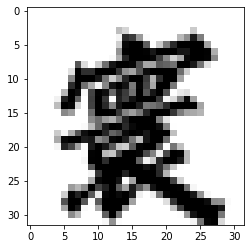

寰


In [37]:

import matplotlib.pyplot as plt


from  PIL import Image

model =  torch.load("model")
model.eval()
with open ("text_json.txt","r",encoding="utf-8") as f:
    text_json = f.read()
    text_json = eval(text_json)
    
path = "test_data/寰_2074.png"
str_ = re.findall("(.*?)_\d+.png",path)[0]

image1 = Image.open(path).convert('RGB')
image = test_image_transform(image1).to(device)
image_ = image.view(1,3,32,32)
pred = model(image_.float())
pred = pred.cpu()
plt.imshow(image1)
plt.show()

print(text_json[pred.argmax().item()])

In [1]:
print(test_label[:10])
print(torch.argmax(predict,dim=1)[:10])

NameError: name 'test_label' is not defined